In [1]:
%matplotlib inline
import random
random.seed(0)
import mlrose
import numpy as np
import seaborn as sns
import warnings
from datetime import datetime
warnings.simplefilter('ignore')
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, GridSearchCV, validation_curve

In [2]:
# Load data
data_white = pd.read_csv('data/winequality-white.csv', delimiter=';')
data_red = pd.read_csv('data/winequality-red.csv', delimiter=';')
data_white["type"] = 0
data_red["type"] = 1

In [3]:
data = data_white.append(data_red, ignore_index=True)
data = data.dropna()

X, y = data.drop('quality', axis=1), data.quality
y = (y<6).astype(int)
y = y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [4]:
kf = KFold(n_splits=5)
acc_tr = {}
time_tr = {}
acc_val = {}
acc_te = {}

def evaluate(algo_name, param_name, clf, kf):
    
    if algo_name not in acc_tr:
        acc_tr[algo_name] = {}
        acc_te[algo_name] = {}
        acc_val[algo_name] = {}
        time_tr[algo_name] = {}
    if param_name not in acc_tr[algo_name]:
        acc_tr[algo_name][param_name] = []
        acc_te[algo_name][param_name] = []
        acc_val[algo_name][param_name] = []
        time_tr[algo_name][param_name] = []
    eval_time = []
    eval_tr = []
    eval_te = []
    eval_val = []
    
    for train_index, val_index in kf.split(X_train):
        x_tr, x_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]
        
        time_start = datetime.now()
        clf.fit(x_tr, y_tr)
        eval_time.append((datetime.now() - time_start).microseconds)
        
        y_train_pred = clf.predict(x_tr)
        y_val_pred = clf.predict(x_val)
        y_train_accuracy = accuracy_score(y_tr, y_train_pred)
        y_val_accuracy = accuracy_score(y_val, y_val_pred)
        eval_tr.append(y_train_accuracy)    
        eval_val.append(y_val_accuracy)
        
        
    eval_time = np.array(eval_time).mean() / 1000
    eval_tr = np.array(eval_tr).mean()
    eval_val = np.array(eval_val).mean()

    y_test_pred = clf.predict(X_test)
    y_test_accuracy = accuracy_score(y_test, y_test_pred)
    
    acc_tr[algo_name][param_name].append(eval_tr)
    acc_val[algo_name][param_name].append(eval_val)
    acc_te[algo_name][param_name].append(y_test_accuracy)    
    time_tr[algo_name][param_name].append(eval_time)
    return eval_val

## Gradient descent

In [5]:
iteration_range = range(300, 1501, 300)

best_val_score = -1
best_clf = ""
for it in iteration_range:
    print("Eval iter", it)

    algo = 'gd'
    clf = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='gradient_descent',
                              max_iters=it, bias=True, is_classifier=True, learning_rate=0.0001, 
                              early_stopping=True, clip_max=1, max_attempts=100)
    score = evaluate(algo, 'iter', clf, kf)
    if best_val_score<score:
        best_val_score = score
        best_clf = clf

Eval iter 300
Eval iter 600
Eval iter 900
Eval iter 1200
Eval iter 1500


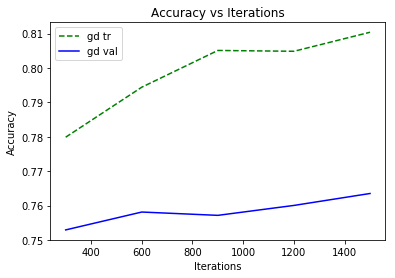

In [13]:
plt.figure(figsize=(10, 10))
plt.plot(iteration_range, acc_tr['gd']['iter'], label='gd tr', linestyle='--', color='g')
plt.plot(iteration_range, acc_val['gd']['iter'], label='gd val', linestyle='-', color='b')

plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.title("Accuracy vs Iterations")
plt.legend(loc='best')

In [7]:
print(classification_report(y_test, best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       862
           1       0.60      0.81      0.69       438

   micro avg       0.76      0.76      0.76      1300
   macro avg       0.74      0.77      0.74      1300
weighted avg       0.79      0.76      0.76      1300



## RHC

In [8]:
iteration_range = range(300, 1501, 300)

best_val_score = -1
best_clf = ""
for it in iteration_range:
    print("Eval iter", it)

    algo = 'rhc'
    clf = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='random_hill_climb',
                              max_iters=it, bias=True, is_classifier=True, learning_rate=0.0001, 
                              early_stopping=True, clip_max=1, max_attempts=100)
    score = evaluate(algo, 'iter', clf, kf)
    if best_val_score<score:
        best_val_score = score
        best_clf = clf

Eval iter 300
Eval iter 600
Eval iter 900
Eval iter 1200
Eval iter 1500


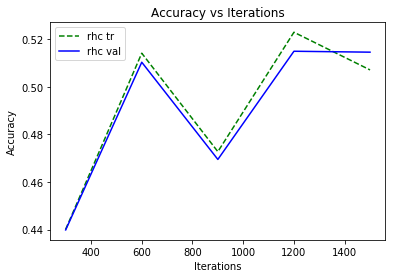

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(iteration_range, acc_tr['rhc']['iter'], label='rhc tr', linestyle='--', color='g')
plt.plot(iteration_range, acc_val['rhc']['iter'], label='rhc val', linestyle='-', color='b')

plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.title("Accuracy vs Iterations")
plt.legend(loc='best')

In [12]:
print(classification_report(y_test, best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.50      0.59       862
           1       0.37      0.58      0.45       438

   micro avg       0.53      0.53      0.53      1300
   macro avg       0.54      0.54      0.52      1300
weighted avg       0.59      0.53      0.54      1300



## SA

In [15]:
iteration_range = range(300, 1501, 300)

best_val_score = -1
best_clf = ""
for it in iteration_range:
    print("Eval iter", it)

    algo = 'sa'
    clf = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='simulated_annealing',
                              max_iters=it, bias=True, is_classifier=True, learning_rate=0.0001, 
                              early_stopping=True, clip_max=1, max_attempts=100)
    score = evaluate(algo, 'iter', clf, kf)
    if best_val_score<score:
        best_val_score = score
        best_clf = clf

Eval iter 300
Eval iter 600
Eval iter 900
Eval iter 1200
Eval iter 1500


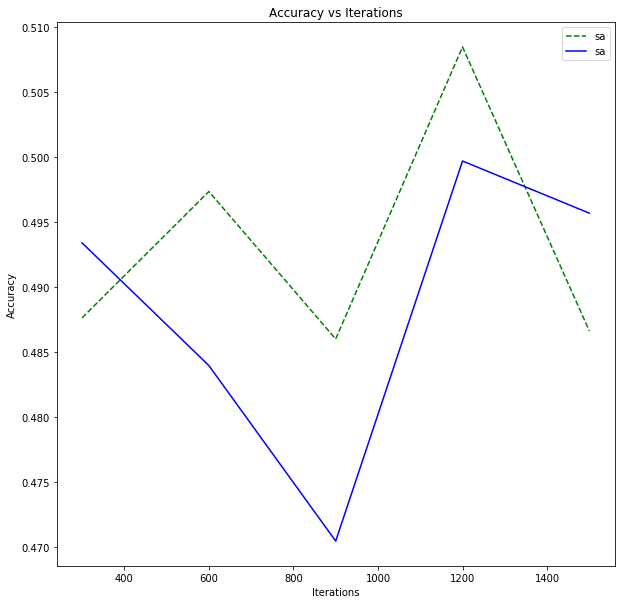

In [16]:
plt.figure(figsize=(10, 10))
plt.plot(iteration_range, acc_tr['sa']['iter'], label='sa', linestyle='--', color='g')
plt.plot(iteration_range, acc_val['sa']['iter'], label='sa', linestyle='-', color='b')

plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.title("Accuracy vs Iterations")
plt.legend(loc='best')

In [17]:
print(classification_report(y_test, best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.89      0.77       862
           1       0.44      0.18      0.26       438

   micro avg       0.65      0.65      0.65      1300
   macro avg       0.56      0.53      0.51      1300
weighted avg       0.60      0.65      0.60      1300



## GA

In [ ]:
iteration_range = range(250, 1501, 250)
for it in iteration_range:
    print("Eval iter", it)
    algo = 'ga'
    clf = mlrose.NeuralNetwork(hidden_nodes=[100], activation='relu', algorithm='genetic_alg',
                              max_iters=it, bias=True, is_classifier=True, learning_rate=0.0001, 
                              early_stopping=True, clip_max=1, max_attempts=100)
    evaluate(algo, 'iter', clf, kf)

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(iteration_range, acc_te['ga']['iter'], label='ga te', linestyle='--', color='g')
plt.plot(iteration_range, acc_tr['ga']['iter'], label='ga val', linestyle='-', color='b')

plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.title("Accuracy vs Iterations")
plt.legend(loc='best')

In [ ]:
print(classification_report(y_test, best_clf.predict(X_test)))

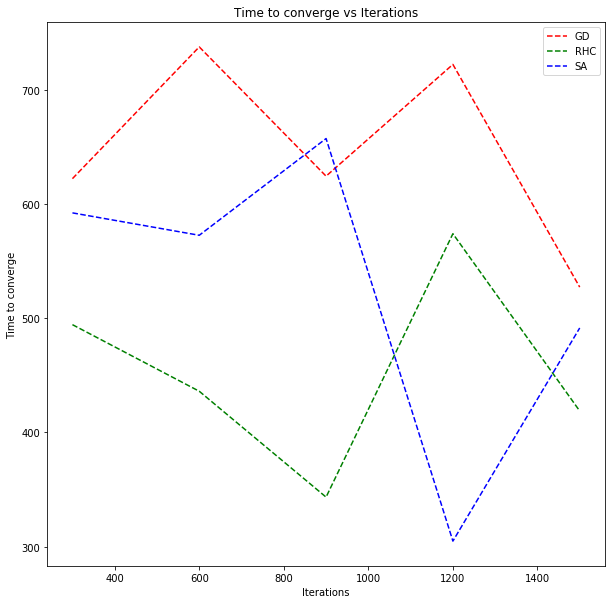

In [23]:
plt.figure(figsize=(10, 10))
plt.plot(iteration_range, time_tr['gd']['iter'], label='GD', linestyle='--', color='r')
plt.plot(iteration_range, time_tr['rhc']['iter'], label='RHC', linestyle='--', color='g')
plt.plot(iteration_range, time_tr['sa']['iter'], label='SA', linestyle='--', color='b')

plt.ylabel("Time to converge")
plt.xlabel("Iterations")
plt.title("Time to converge vs Iterations")
plt.legend(loc='best')